# NLP word embedding-> Final version

TO DO
- Hashtags
- tfidf test
- Often combined with dimension reduction:
restriction to an interesting vocabulary
use of principal component analysis (latent semantic analysis): Latent Semantic Analysis= PCA of this representation tfidf


In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor



c:\Users\maria\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


This include all NLP approaches for word embedding

Prediction of Likes and Retweets Using Text Information Retrieval
https://ai.intelligentonlinetools.com/ml/text-clustering-doc2vec-word-embedding-machine-learning/

Paper:
1-s2.0-S1877050920304129-main.pdf


Le github magique:
https://github.com/buomsoo-kim/Word-embedding-with-Python

French corpus: https://stackoverflow.com/questions/42058396/python-nltk-and-textblob-in-french

## Data

In [2]:
# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")


# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)

# Traitement du texte

# Model with Doc2Vec

In [56]:
#use nlp model fro text train data
#import doc2vec
from gensim.models.doc2vec import Doc2Vec
model = Doc2Vec.load('doc2vec_model')

print("starting vectoring X_train")

X_train_doc = X_train['text'].apply(lambda x: model.infer_vector([x]))
#use nlp model fro text eval data
print("starting vectoring X_test")
X_test_doc = X_test['text'].apply(lambda x: model.infer_vector([x]))

#expected duration: 30min


starting vectoring X_train
starting vectoring X_test


In [57]:
#x_train_doc to df
X_train_doc = pd.DataFrame(X_train_doc.values.tolist())
X_test_doc = pd.DataFrame(X_test_doc.values.tolist())


## Pipeline

In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', MinMaxScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', MinMaxScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', MinMaxScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
pipelines.append(('ScaledMLP', Pipeline([('Scaler', MinMaxScaler()),('MLP', MLPRegressor())])))



results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_doc, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


ScaledGBM: -26.917665 (1.228420)
ScaledRF: -31.624147 (1.196887)
ScaledMLP: -26.749918 (1.916168)


Sans pca, min max
- ScaledLR: -26.794943 (1.228909)
- ScaledLASSO: -26.789938 (1.227422)
- ScaledEN: -26.789938 (1.227422)
- ScaledKNN: -29.097677 (1.227968)
- ScaledCART: -32.256769 (1.919832)
- ScaledGBM: -26.917665 (1.228420)
- ScaledRF: -31.624147 (1.196887)
- ScaledMLP: -26.749918 (1.916168)

# Model with Spacy text embedding



In [8]:
import spacy
# Load the spacy model that you have installed
nlp = spacy.load('fr_core_news_sm')# python -m spacy download fr_core_news_sm
# process a sentence using the model
doc = nlp("Macron démission")
# It's that simple - all of the vectors and words are assigned after this point
# Get the vector for 'text':
doc.vector


array([ 2.77224708e+00, -8.20644140e-01, -3.03102303e+00,  1.71295309e+00,
       -1.51811123e-01, -6.19174361e-01,  8.30909967e-01,  3.04782152e+00,
        3.13939261e+00, -3.14197016e+00,  3.75156593e+00,  7.06376970e-01,
        4.97845650e-01, -7.39134669e-01, -1.51396203e+00, -6.00879252e-01,
        1.98837304e+00, -1.65502715e+00, -2.15656042e-01, -3.06843376e+00,
       -2.57701969e+00, -6.50485158e-02, -1.93754995e+00, -1.44916689e+00,
       -1.40775919e+00, -3.76376247e+00,  7.35826492e-02,  5.47314596e+00,
        2.39667892e+00, -1.73095465e-02, -3.04729295e+00,  3.57966995e+00,
       -4.89883900e-01,  1.82727182e+00, -7.40789533e-01, -2.31122684e+00,
       -6.91391945e-01, -1.97245240e+00,  6.30308867e-01, -3.27573270e-01,
       -3.56692076e-01, -8.23963046e-01,  3.11563540e+00, -4.16857243e+00,
       -1.66391611e+00, -2.21248603e+00,  2.82474899e+00,  5.70967078e-01,
        5.85822582e-01,  2.84727335e+00,  4.80433702e-01, -8.01777303e-01,
       -3.93913603e+00, -

In [9]:
#use nlp model fro text train data
print("starting vectoring X_train")

X_train_spa = X_train['text'].apply(lambda x: nlp(x).vector)
#use nlp model fro text eval data
print("starting vectoring X_test")
X_test_spa = X_test['text'].apply(lambda x: nlp(x).vector)

#expected duration: 30min


starting vectoring X_train


KeyboardInterrupt: 

In [5]:
#X_test_txt to pd
X_test_spa = pd.DataFrame(X_test_spa.to_list())
#X_train_txt to pd
X_train_spa = pd.DataFrame(X_train_spa.to_list())



### PCA to reduce dimension




In [62]:
#import pca
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_train_spa_pca = pca.fit_transform(X_train_spa)
X_test_spa_pca = pca.transform(X_test_spa)


## Pipeline

In [10]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


pipelines = []
#pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
#pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
#pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
#pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
#pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
#pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
#pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
pipelines.append(('ScaledMLP', Pipeline([('Scaler', StandardScaler()),('MLP', MLPRegressor())])))



results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_spa, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



ScaledMLP: -43.750764 (4.056548)


Sans PCA (53min), standard:

- Text GB spacy 26.827508922601726
- Text MLP spacy 30.977323878671452
- Text RF spacy 35.9382998559199



PCA=10 components (126min), standard):
- ScaledLR: -26.814401 (1.000995)
- ScaledLASSO: -26.780504 (1.006401)
- ScaledEN: -26.780629 (1.003824)
- ScaledKNN: -29.531135 (1.171399)
- ScaledCART: -32.986936 (1.122446)
- ScaledGBM: -26.696848 (1.031312)
- ScaledRF: -30.585169 (0.964902)
- ScaledMLP: -27.521220 (0.938561)












PCA=10, MinMax
- ScaledLR: -26.814388 (1.000974)
- ScaledLASSO: -26.878887 (1.000569)
- ScaledEN: -26.878887 (1.000569)
- ScaledKNN: -29.499869 (1.200428)
- ScaledCART: -33.103061 (1.433910)
- ScaledGBM: -26.720753 (1.023079)
- ScaledRF: -31.792145 (0.712734)
- ScaledMLP: -26.933599 (1.345101)

Sans PCA, MinMax
- ScaledLR: -27.270481 (1.199289)
- ScaledLASSO: -26.668859 (1.218327)
- ScaledEN: -26.677875 (1.215340)
- ScaledKNN: -35.197787 (1.282964)
- ScaledCART: -37.951425 (2.477564)
- ScaledGBM: -26.927640 (1.240835)
- ScaledRF: -36.567023 (1.618142)
- ScaledMLP: -43.750764 (4.056548)



# Model with itdf vectorizer word embedding


In [64]:
# We set up an Tfidf Vectorizer that will use the top 100 tokens from the tweets. We also remove stopwords.
# To do that we have to fit our training dataset and then transform both the training and testing dataset. 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
#import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

vectorizer = TfidfVectorizer(max_features=20, stop_words=stopwords.words('french'))
X_train_tfidf = vectorizer.fit_transform(X_train['text'])
X_test_tfidf = vectorizer.transform(X_test['text'])
#Xtrain_tfidf to data frame
X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray())
#Xtest_tfidf to data frame
X_test_tfidf = pd.DataFrame(X_test_tfidf.toarray())


## PCA to reduce dimension

In [65]:
#import pca
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf)
X_test_tfidf_pca = pca.transform(X_test_tfidf)

## Pipeline

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', MinMaxScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', MinMaxScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', MinMaxScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
pipelines.append(('ScaledMLP', Pipeline([('Scaler', MinMaxScaler()),('MLP', MLPRegressor())])))



results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_tfidf, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_tfidf_pca, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -26.933404 (1.230478)
ScaledLASSO: -26.677275 (1.224890)
ScaledEN: -26.759018 (1.226980)
ScaledKNN: -22.265286 (6.088496)
ScaledCART: -26.861317 (1.181888)
ScaledGBM: -26.631646 (1.204244)
ScaledRF: -26.764250 (1.177280)
ScaledMLP: -26.851509 (1.612895)
ScaledLR: -26.937340 (1.229162)
ScaledLASSO: -26.746514 (1.228104)
ScaledEN: -26.772366 (1.227235)
ScaledKNN: -22.409032 (5.797070)
ScaledCART: -27.026435 (1.117909)
ScaledGBM: -26.621082 (1.191008)
ScaledRF: -26.927973 (1.225531)
ScaledMLP: -26.932314 (1.456901)


tf iDF, no PCA, standard scaler (90min), 100 features
- ScaledLR: -27.557247 (1.407570)
- ScaledLASSO: -27.059340 (1.411149)
- ScaledEN: -26.827886 (1.419568)
- ScaledKNN: -26.216037 (2.116711)
- ScaledCART: -27.195570 (1.765834)
- ScaledGBM: -26.544806 (1.342096)
- RF: 27.29356819425202 (2.000632)
- MLP: 35.71786302100322 (1.75285)

tf iDF, PCA=10, standard scaler, 100 features
- ScaledLR: -27.285818 (1.267277)
- ScaledLASSO: -26.949566 (1.264834)
- ScaledEN: -26.845382 (1.272532)
- ScaledKNN: -25.496026 (1.802925)
- ScaledCART: -28.929126 (1.969090)
- ScaledGBM: -26.790425 (1.299460)
- ScaledRF: -28.346692 (1.517844)
- ScaledMLP: -26.533785 (1.173627)

tf iDF, PCA=20, standard scaler, 100 features
- ScaledLR: -27.361372 (1.299267)
- ScaledLASSO: -26.914105 (1.277699)
- ScaledEN: -26.801447 (1.284229)
- ScaledKNN: -26.405744 (1.742108)
- ScaledCART: -28.993623 (1.590775)
- ScaledGBM: -26.709120 (1.258245)
- ScaledRF: -28.665107 (1.547948)
- Scaked MLP:-28.177143 (1.757813)

tf iDF, no PCA, standard scaler (90min), 10 features

- ScaledLR: -27.086136 (1.261524)
- ScaledLASSO: -26.805272 (1.259687)
- ScaledEN: -26.806091 (1.266831)
- ScaledKNN: -35.788074 (7.720180)
- ScaledCART: -26.848741 (1.312968)
- ScaledGBM: -26.779600 (1.299676)
- ScaledRF: -26.801263 (1.336147)
- ScaledMLP: -26.799349 (1.388996)

tfidf minmax sans pca
- ScaledLR: -26.933404 (1.230478)
- ScaledLASSO: -26.677275 (1.224890)
- ScaledEN: -26.759018 (1.226980)
- ScaledKNN: -22.265286 (6.088496)
- ScaledCART: -26.861317 (1.181888)
- ScaledGBM: -26.631646 (1.204244)
- ScaledRF: -26.764250 (1.177280)
- ScaledMLP: -26.851509 (1.612895)

tfidf minmax  pca=10
- ScaledLR: -26.937340 (1.229162)
- ScaledLASSO: -26.746514 (1.228104)
- ScaledEN: -26.772366 (1.227235)
- ScaledKNN: -22.409032 (5.797070)
- ScaledCART: -27.026435 (1.117909)
- ScaledGBM: -26.621082 (1.191008)
- ScaledRF: -26.927973 (1.225531)
- ScaledMLP: -26.932314 (1.456901)

# Traitement des Hashtags

100


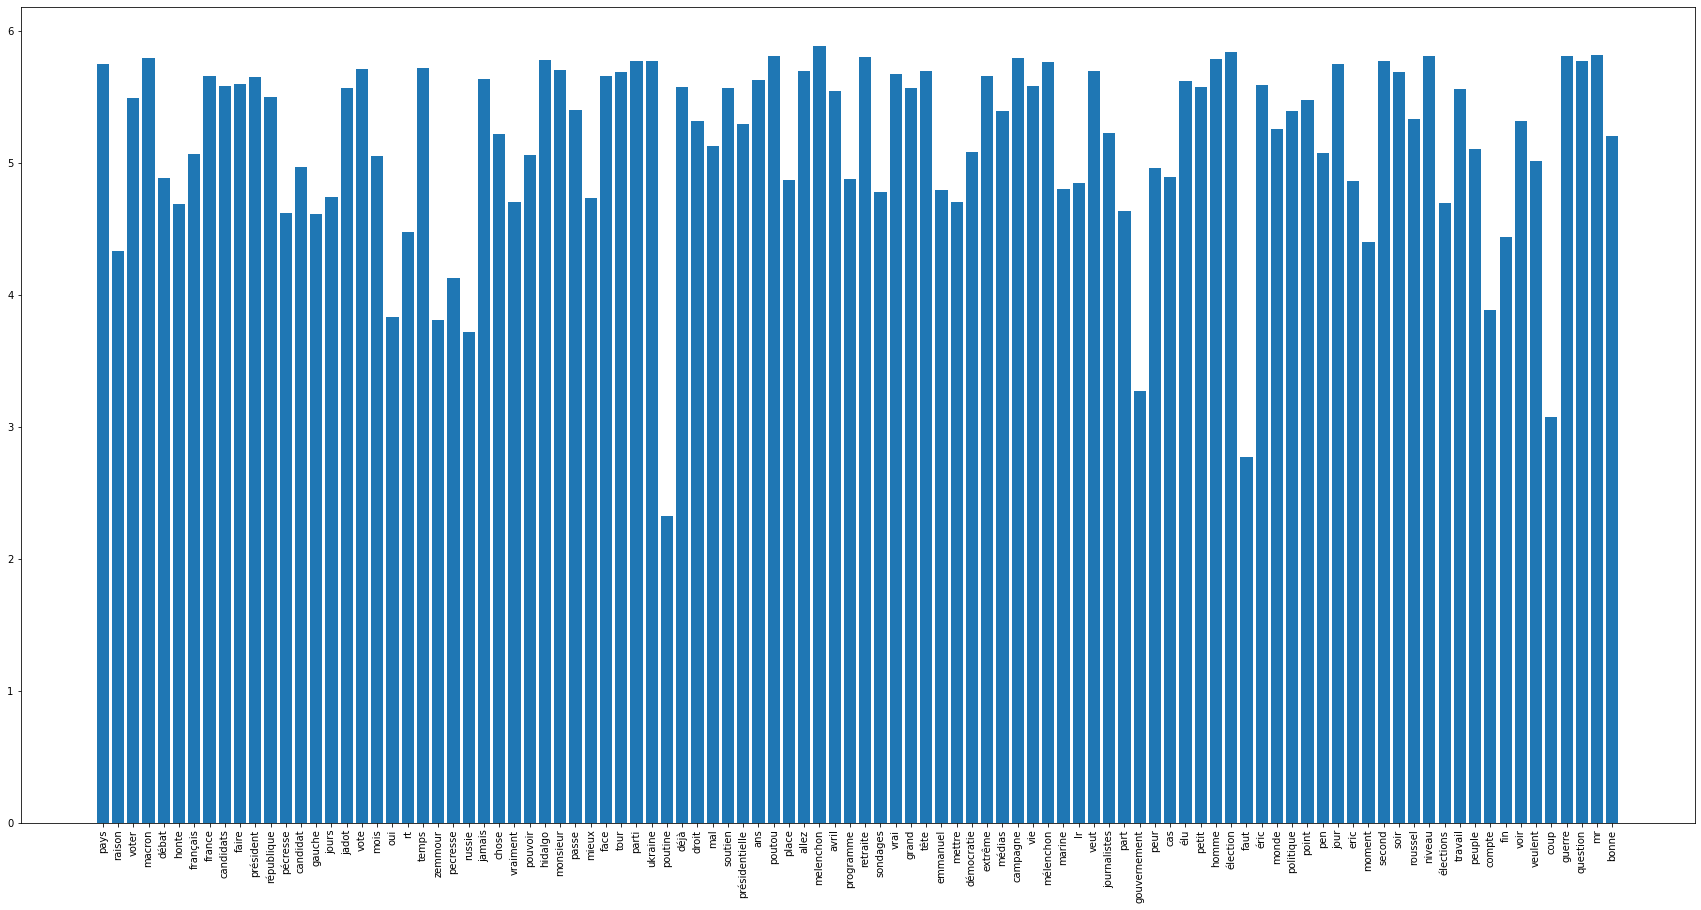

In [67]:

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
vectorizer2 = TfidfVectorizer(max_features=100, stop_words=stopwords.words('french')) 
# show vocabulary
vectorizer2.fit(X_train['text'])
print(len(vectorizer2.vocabulary_))
# histogram of the vocabulary
plt.figure(figsize=(30,15))
plt.bar(range(len(vectorizer2.vocabulary_)), vectorizer2.idf_)
#plt.bar(range(len(vectorizer2.vocabulary_)), vectorizer2.vocabulary_.values())
plt.xticks(range(len(vectorizer2.vocabulary_)), list(vectorizer2.vocabulary_.keys()), rotation=90)
plt.show()



# show document feature vectors
X_train_tfidf2 = vectorizer2.transform(X_train['text'])
X_test_tfidf2 = vectorizer2.transform(X_test['text'])
#Xtrain_tfidf to data frame
X_train_tfidf2 = pd.DataFrame(X_train_tfidf2.toarray())
#Xtest_tfidf to data frame
X_test_tfidf2 = pd.DataFrame(X_test_tfidf2.toarray())

#pca
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_train_tfidf2_pca = pca.fit_transform(X_train_tfidf2)
X_test_tfidf2_pca = pca.transform(X_test_tfidf2)
#Xtrain_tfidf to data frame
X_train_tfidf2_pca = pd.DataFrame(X_train_tfidf2_pca)
#Xtest_tfidf to data frame
X_test_tfidf2_pca = pd.DataFrame(X_test_tfidf2_pca)







## Pipeline

In [68]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', MinMaxScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', MinMaxScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', MinMaxScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
pipelines.append(('ScaledMLP', Pipeline([('Scaler', MinMaxScaler()),('MLP', MLPRegressor())])))


results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_tfidf2, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_tfidf2_pca, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



ScaledLR: -27.117114 (1.201309)
ScaledLASSO: -26.732072 (1.227426)
ScaledEN: -26.774386 (1.227401)
ScaledKNN: -27.788319 (2.870575)
ScaledCART: -27.173882 (1.519743)
ScaledGBM: -26.438463 (1.143124)
ScaledRF: -26.752734 (1.370168)
ScaledMLP: -30.979654 (1.734530)
ScaledLR: -27.093443 (1.229531)
ScaledLASSO: -26.789938 (1.227422)
ScaledEN: -26.781203 (1.227426)
ScaledKNN: -28.406512 (2.400761)
ScaledCART: -28.706214 (1.562175)
ScaledGBM: -26.591241 (1.182669)
ScaledRF: -28.318641 (1.040205)
ScaledMLP: -26.444636 (1.278506)


hash itfdf sans pca
- ScaledLR: -27.117114 (1.201309)
- ScaledLASSO: -26.732072 (1.227426)
- ScaledEN: -26.774386 (1.227401)
- ScaledKNN: -27.788319 (2.870575)
- ScaledCART: -27.173882 (1.519743)
- ScaledGBM: -26.438463 (1.143124)
- ScaledRF: -26.752734 (1.370168)
- ScaledMLP: -30.979654 (1.734530)

hash iftdf pca=10

- ScaledLR: -27.093443 (1.229531)
- ScaledLASSO: -26.789938 (1.227422)
- ScaledEN: -26.781203 (1.227426)
- ScaledKNN: -28.406512 (2.400761)
- ScaledCART: -28.706214 (1.562175)
- ScaledGBM: -26.591241 (1.182669)
- ScaledRF: -28.318641 (1.040205)
- ScaledMLP: -26.444636 (1.278506